In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [2]:
dataset = MNIST(root="~/Datasets", train=True, download=False, transform=transforms.ToTensor())
Xtsr = dataset.data.float() / 255
Xtrain = Xtsr.reshape(Xtsr.shape[0], -1)
ytrain = dataset.targets
Xtrain_norm = (Xtrain - Xtrain.mean()) / Xtrain.std()


In [ ]:
# multi-head attention
ndim = 784
n_centroids = 10
n_hidden = 64
n_dot = 64
Wq = nn.Linear(ndim, n_dot)
Wk = nn.Linear(ndim, n_dot)
Wv = nn.Linear(ndim, n_hidden)
Wo = nn.Linear(n_hidden, ndim)
centroids = torch.randn(n_centroids, ndim)

In [ ]:
npnts = 100
x = torch.randn(npnts, ndim)
attn = Wq(x) @ Wk(centroids).T
attn_score = F.softmax(attn / np.sqrt(n_dot), dim=1)
out = Wo(attn_score @ Wv(centroids))

In [5]:
from torch.optim import Adam
from tqdm import trange
def marginal_prob_std(t, sigma):
  """Note that this std -> 0, when t->0
  So it's not numerically stable to sample t=0 in the dataset
  Note an earlier version missed the sqrt...
  """
  return torch.sqrt( (sigma**(2*t) - 1) / 2 / torch.log(torch.tensor(sigma)) ) # sqrt fixed Jun.19


def denoise_loss_fn(model, x, marginal_prob_std_f, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability, sample t uniformly from [eps, 1.0]
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std_f(random_t,)
  perturbed_x = x + z * std[:, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=(1)))
  return loss


def train_score_td(X_train_tsr, score_model_td=None,
                   sigma=25,
                   lr=0.005,
                   nepochs=750,
                   eps=1E-3,
                   batch_size=None,
                   clipnorm=None,
                   scheduler_fun=None,
                   device="cpu",
                   callback_func=lambda score_model_td, epochs, loss: None,
                   callback_epochs=[]):
    ndim = X_train_tsr.shape[1]
    if score_model_td is None:
        score_model_td = ScoreModel_Time_edm(sigma=sigma, ndim=ndim)
    marginal_prob_std_f = lambda t: marginal_prob_std(t, sigma)
    optim = Adam(score_model_td.parameters(), lr=lr)
    if scheduler_fun is not None:
        scheduler = scheduler_fun(optim, )
    score_model_td.to(device)
    X_train_tsr = X_train_tsr.to(device)
    score_model_td.train()
    pbar = trange(nepochs)
    loss_traj = []
    for ep in pbar:
        if batch_size is None:
            loss = denoise_loss_fn(score_model_td, X_train_tsr, marginal_prob_std_f, eps=eps)
        else:
            idx = torch.randint(0, X_train_tsr.shape[0], (batch_size,))
            loss = denoise_loss_fn(score_model_td, X_train_tsr[idx], marginal_prob_std_f, eps=eps)

        optim.zero_grad()
        loss.backward()
        if clipnorm is not None:
            torch.nn.utils.clip_grad_norm_(score_model_td.parameters(),
                                           max_norm=clipnorm)
        optim.step()
        if scheduler_fun is not None:
            scheduler.step()
            pbar.set_description(f"step {ep} loss {loss.item():.3f} lr {scheduler.get_last_lr()[0]:.1e}")
        else:
            pbar.set_description(f"step {ep} loss {loss.item():.3f}")
        if ep == 0:
            print(f"step {ep} loss {loss.item():.3f}")
        if ep in callback_epochs:
            callback_func(score_model_td, ep, loss)
        loss_traj.append(loss.item())
    return score_model_td, loss_traj


def reverse_diffusion_time_dep(score_model_td, sampN=500, sigma=5, nsteps=200, ndim=2, exact=False, device="cpu"):
  """
  score_model_td: if `exact` is True, use a gmm of class GaussianMixture
                  if `exact` is False. use a torch neural network that takes vectorized x and t as input.
  """
  lambdaT = (sigma**2 - 1) / (2 * np.log(sigma))
  xT = np.sqrt(lambdaT) * np.random.randn(sampN, ndim)
  x_traj_rev = np.zeros((*xT.shape, nsteps, ))
  x_traj_rev[:,:,0] = xT
  dt = 1 / nsteps
  for i in range(1, nsteps):
    t = 1 - i * dt
    tvec = torch.ones((sampN)) * t
    eps_z = np.random.randn(*xT.shape)
    if exact:
      gmm_t = diffuse_gmm(score_model_td, t, sigma)
      score_xt = gmm_t.score(x_traj_rev[:,:,i-1])
    else:
      with torch.no_grad():
        score_xt = score_model_td(torch.tensor(x_traj_rev[:,:,i-1]).float().to(device), tvec.to(device)).cpu().numpy()
    # simple Euler-Maryama integration of SGD
    x_traj_rev[:,:,i] = x_traj_rev[:,:,i-1] + eps_z * (sigma ** t) * np.sqrt(dt) + score_xt * dt * sigma**(2*t)
  return x_traj_rev


def reverse_diffusion_time_dep_torch(score_model_td, sampN=500, sigma=5, nsteps=200, ndim=2, exact=False, device="cpu"):
  """More efficient version that run solely on device
  score_model_td: if `exact` is True, use a gmm of class GaussianMixture
                  if `exact` is False. use a torch neural network that takes vectorized x and t as input.
  """
  lambdaT = (sigma**2 - 1) / (2 * math.log(sigma))
  xT = math.sqrt(lambdaT) * torch.randn(sampN, ndim, device=device)
  x_traj_rev = torch.zeros((sampN, ndim, nsteps), device="cpu")
  x_traj_rev[:, :, 0] = xT.cpu()
  dt = 1 / nsteps
  x_next = xT
  for i in range(1, nsteps):
      t = 1 - i * dt
      tvec = torch.ones((sampN,), device=device) * t
      eps_z = torch.randn_like(xT)
      with torch.no_grad():
        score_xt = score_model_td(x_next, tvec)
      # if exact:
      #     gmm_t = diffuse_gmm(score_model_td, t, sigma, device)
      #     score_xt = gmm_t.score(x_traj_rev[:, :, i-1])
      # else:
      x_next = x_next + eps_z * (sigma ** t) * math.sqrt(dt) + score_xt * dt * sigma**(2*t)
      x_traj_rev[:, :, i] = x_next.cpu()

  return x_traj_rev


In [6]:
import math
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps.
  Basically it multiplexes a scalar `t` into a vector of `sin(2 pi k t)` and `cos(2 pi k t)` features.
  """
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

  def forward(self, t):
    t_proj = t.view(-1, 1) * self.W[None, :] * 2 * math.pi
    return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)


class DotAttention(nn.Module):
    def __init__(self, ndim, n_centroids, n_dot, n_hidden):
        super().__init__()
        self.ndim = ndim
        self.n_centroids = n_centroids
        self.n_dot = n_dot
        self.n_hidden = n_hidden
        self.Wq = nn.Linear(ndim, n_dot)
        self.Wk = nn.Linear(ndim, n_dot)
        self.Wv = nn.Linear(ndim, n_hidden)
        self.Wo = nn.Linear(n_hidden, ndim)
        self.centroids = nn.Parameter(torch.randn(n_centroids, ndim))

    def forward(self, x):
        attn = self.Wq(x) @ self.Wk(self.centroids).T
        attn_score = F.softmax(attn / np.sqrt(self.n_dot), dim=1)
        out = self.Wo(attn_score @ self.Wv(self.centroids))
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, ndim, n_centroids, n_dot, n_hidden, n_heads):
        super().__init__()
        self.ndim = ndim
        self.n_centroids = n_centroids
        self.n_dot = n_dot
        self.n_hidden = n_hidden
        self.n_heads = n_heads
        self.Wq = nn.Linear(ndim, n_dot * n_heads)
        self.Wk = nn.Linear(ndim, n_dot * n_heads)
        self.Wv = nn.Linear(ndim, n_hidden * n_heads)
        self.Wo = nn.Linear(n_hidden * n_heads, ndim)
        self.centroids = nn.Parameter(torch.randn(n_centroids, ndim))
        self.centroids.data = self.centroids.data / self.centroids.data.norm(dim=1, keepdim=True)

    def forward(self, x):
        query = self.Wq(x)
        key = self.Wk(self.centroids)
        value = self.Wv(self.centroids)
        # split heads
        query = query.reshape(query.shape[0], self.n_heads, self.n_dot)
        key = key.reshape(key.shape[0], self.n_heads, self.n_dot)
        value = value.reshape(value.shape[0], self.n_heads, self.n_hidden)
        # attention
        attn = torch.einsum("Bhd,Chd->hBC", query, key)  # head x batch x centroid
        attn_score = F.softmax(attn / np.sqrt(self.n_dot), dim=-1)  # head x batch x centroid
        head_values = torch.einsum("hBC,Chd->Bhd", attn_score, value)  # batch x head x hidden
        # merge heads
        out = self.Wo(head_values.reshape(head_values.shape[0], -1))
        return out


mha = MultiHeadAttention(ndim, n_centroids, n_dot, n_hidden, n_heads=4)
out = mha(x)

NameError: name 'ndim' is not defined

In [13]:
class ModulatedDotAttention(nn.Module):
    def __init__(self, ndim, n_centroids, n_dot, n_hidden, time_embed_dim):
        super().__init__()
        self.Wq = nn.Linear(ndim, n_dot)
        self.Wk = nn.Linear(ndim, n_dot)
        self.Wv = nn.Linear(ndim, n_hidden)
        self.Wo = nn.Linear(n_hidden, ndim)
        self.centroids = nn.Parameter(torch.randn(n_centroids, ndim))
        self.centroids.data = self.centroids.data / self.centroids.data.norm(dim=1, keepdim=True)
        self.sigma_embed = GaussianFourierProjection(time_embed_dim)
        self.sigma_mod1 = nn.Linear(time_embed_dim, n_dot)
        self.sigma_mod2 = nn.Linear(time_embed_dim, n_hidden)

    def forward(self, x, sigma):
        sigma_emb = self.sigma_embed(sigma)
        mod1 = self.sigma_mod1(sigma_emb)  # batch x n_dot
        mod2 = self.sigma_mod2(sigma_emb)  # batch x n_hidden
        attn = (self.Wq(x) * mod1) @ self.Wk(self.centroids).T
        attn_score = F.softmax(attn / np.sqrt(n_dot), dim=1)
        out = self.Wo(mod2 * (attn_score @ self.Wv(self.centroids)))
        return out


class ModulatedMultiHeadAttention(nn.Module):
    def __init__(self, ndim, n_centroids, n_dot, n_hidden, n_heads, time_embed_dim):
        super().__init__()
        self.ndim = ndim
        self.n_centroids = n_centroids
        self.n_dot = n_dot
        self.n_hidden = n_hidden
        self.n_heads = n_heads
        self.Wq = nn.Linear(ndim, n_dot * n_heads)
        self.Wk = nn.Linear(ndim, n_dot * n_heads)
        self.Wv = nn.Linear(ndim, n_hidden * n_heads)
        self.Wo = nn.Linear(n_hidden * n_heads, ndim)
        self.centroids = nn.Parameter(torch.randn(n_centroids, ndim))
        self.centroids.data = self.centroids.data / self.centroids.data.norm(dim=1, keepdim=True)
        self.sigma_embed = GaussianFourierProjection(time_embed_dim)
        self.sigma_mod1 = nn.Linear(time_embed_dim, n_dot)
        self.sigma_mod2 = nn.Linear(time_embed_dim, n_hidden)

    def forward(self, x, sigma):
        sigma_emb = self.sigma_embed(sigma)
        mod1 = self.sigma_mod1(sigma_emb)  # batch x n_dot
        mod2 = self.sigma_mod2(sigma_emb)  # batch x n_hidden
        query = self.Wq(x)
        key = self.Wk(self.centroids)
        value = self.Wv(self.centroids)
        # split heads
        query = query.reshape(query.shape[0], self.n_heads, self.n_dot)
        key = key.reshape(key.shape[0], self.n_heads, self.n_dot)
        value = value.reshape(value.shape[0], self.n_heads, self.n_hidden)
        # attention
        attn = torch.einsum("Bhd,Chd->hBC", query * mod1[:, None, :], key)  # head x batch x centroid
        attn_score = F.softmax(attn / np.sqrt(self.n_dot), dim=-1)  # head x batch x centroid
        head_values = torch.einsum("hBC,Chd->Bhd", attn_score, value)  # batch x head x hidden
        head_values = head_values * mod2[:, None, :]
        # merge heads
        out = self.Wo(head_values.reshape(head_values.shape[0], -1))
        return out



In [16]:
npnts = 100
ndim = 784
n_centroids = 10
n_dot = 64
n_hidden = 64
x = torch.randn(npnts, ndim)
mda = ModulatedDotAttention(ndim, n_centroids, n_dot, n_hidden, time_embed_dim=64)
out = mda(x, torch.randn(npnts))
mmha = ModulatedMultiHeadAttention(ndim, n_centroids, n_dot, n_hidden, n_heads=4, time_embed_dim=64)
out = mmha(x, torch.randn(npnts))

In [17]:
class ModulatedResBlock(nn.Module):
    def __init__(self, ndim, n_centroids, n_dot, n_hidden, n_heads,
                 mlp_proj_dim, time_embed_dim):
        super().__init__()
        self.mha = ModulatedMultiHeadAttention(ndim, n_centroids, n_dot, n_hidden, n_heads, time_embed_dim)
        self.sigma_embed = GaussianFourierProjection(time_embed_dim)
        self.sigma_gate1 = nn.Linear(time_embed_dim, 1)
        self.sigma_gate2 = nn.Linear(time_embed_dim, 1)
        self.sigma_gate3 = nn.Linear(time_embed_dim, 1)
        self.norm1 = nn.LayerNorm(ndim)
        self.norm2 = nn.LayerNorm(ndim)
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.1)
        self.lin1 = nn.Linear(ndim, mlp_proj_dim)
        self.lin2 = nn.Linear(mlp_proj_dim, ndim)

    def forward(self, x, sigma):
        sigma_emb = self.sigma_embed(sigma)
        gate1 = self.sigma_gate1(sigma_emb)
        gate2 = self.sigma_gate2(sigma_emb)  # maybe use sigmoid
        gate3 = self.sigma_gate3(sigma_emb)
        attn = self.mha(x, sigma)
        x = self.norm1(gate1 * x + gate2 * attn)
        out = x + gate3 * F.relu(self.lin2(F.relu(self.lin1(x))))
        return out
        # x = self.norm1(x + self.drop1(attn))
        # x = self.norm2(x + self.drop2(F.relu(self.lin2(F.relu(self.lin1(x))))))
        # return x

In [18]:
class ModulatedSequential(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)

    def forward(self, x, sigma):
        for module in self:
            x = module(x, sigma)
        return x

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Single Multi head attention.

In [26]:
ndim = Xtrain_norm.shape[1]
n_centroids = 32
n_hidden = 128
n_dot = 128
n_heads = 24
time_embed_dim = 32
sigma_max = 10
epochs = 10000
batch_size = 2048
mmha = ModulatedMultiHeadAttention(ndim, n_centroids, n_dot, n_hidden,
                   n_heads=n_heads, time_embed_dim=time_embed_dim)
print("Parameter count", count_parameters(mmha))
mmha, loss_traj = train_score_td(Xtrain_norm, score_model_td=mmha,
        sigma=sigma_max, lr=0.001, nepochs=epochs, batch_size=batch_size, device="cuda:0",)
                      # clipnorm=1)

Parameter count 9677328


step 22 loss 783.393:   0%|          | 13/10000 [00:00<01:17, 128.78it/s]

step 0 loss 785.782


step 9999 loss 187.600: 100%|██████████| 10000/10000 [01:04<00:00, 155.88it/s]


number of parameters 9677328


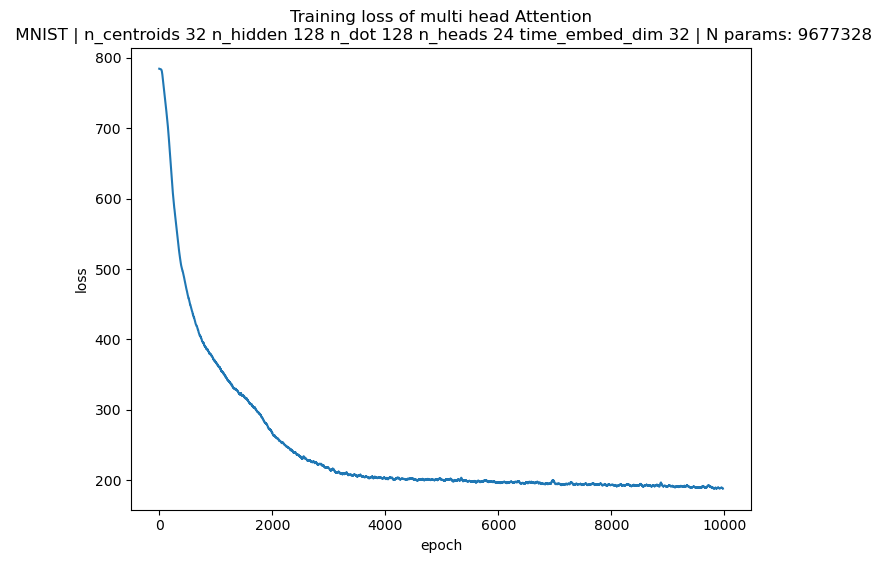

In [27]:
num_params = sum(p.numel() for p in mmha.parameters() if p.requires_grad)
print("number of parameters", num_params)
# 6 million parameters
ker_wid = 25
smooth_loss_traj = np.convolve(loss_traj, np.ones(ker_wid)/ker_wid, mode='valid')
plt.figure(figsize=[8,6])
plt.plot(smooth_loss_traj)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title(f"Training loss of multi head Attention\n MNIST | n_centroids {n_centroids} n_hidden {n_hidden} n_dot {n_dot} n_heads {n_heads} time_embed_dim {time_embed_dim} "\
          f"| N params: {num_params}")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


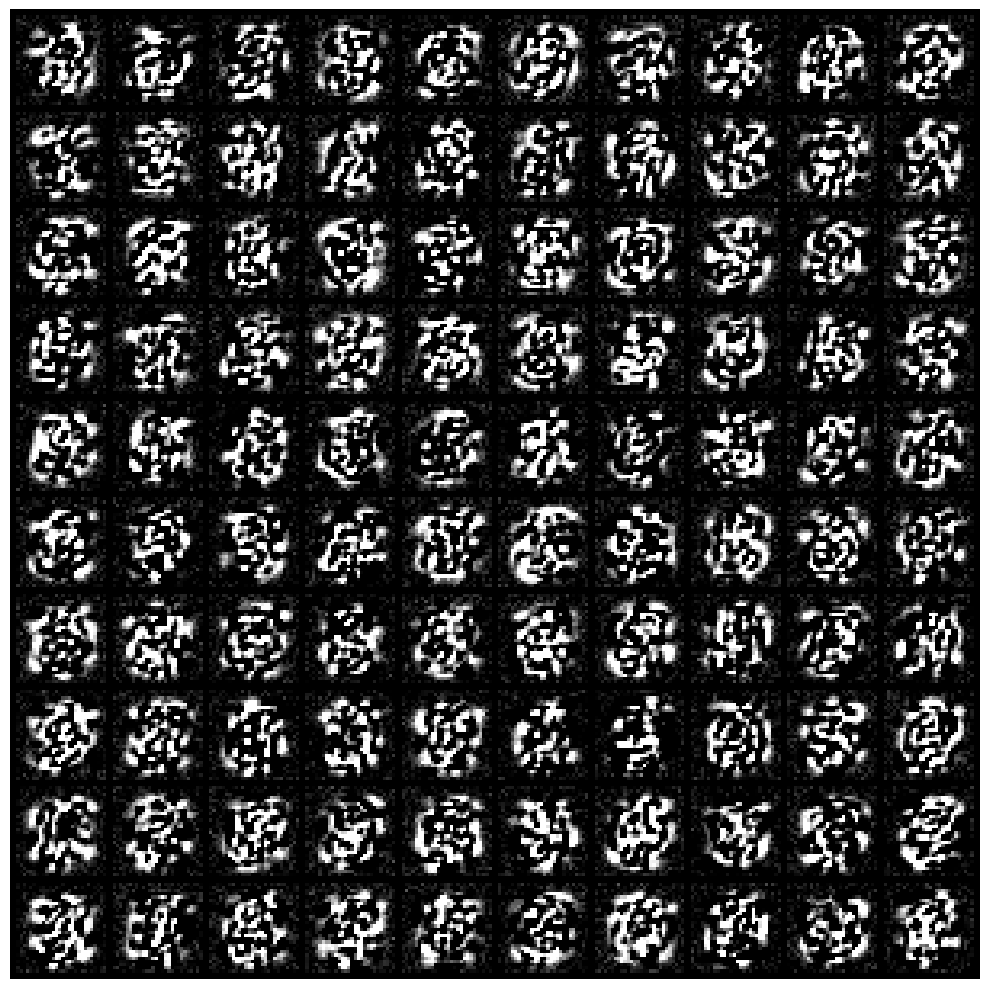

In [28]:
samples = reverse_diffusion_time_dep_torch(mmha, 
        sampN=100, sigma=sigma_max, nsteps=1000, ndim=ndim, 
        exact=False, device="cuda")
samples_denorm = samples * Xtrain.std() + Xtrain.mean()
mtg = make_grid(samples_denorm[:,:,-1].reshape(-1, 1, 28, 28), nrow=10)
plt.figure(figsize=[10,10])
plt.imshow(mtg.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout()
plt.show()

### Single layer mha res net.

In [32]:
ndim = Xtrain_norm.shape[1]
n_centroids = 128
n_hidden = 128
n_dot = 128
n_heads = 64
time_embed_dim = 32
mlp_proj_dim = 256
sigma_max = 10
epochs = 20000
batch_size = 2048
mmres = ModulatedResBlock(ndim, n_centroids, n_dot, n_hidden,
                   n_heads=n_heads, time_embed_dim=time_embed_dim,
                         mlp_proj_dim=mlp_proj_dim)
print("Parameter count: ", count_parameters(mmha))
mmres, loss_traj = train_score_td(Xtrain_norm, score_model_td=mmres,
        sigma=sigma_max, lr=0.001, nepochs=epochs, batch_size=batch_size, device="cuda",)
# very fast to train
# Parameter count:  2457187
# step 0 loss 4156.395:   0%|          | 0/5000 [00:00<?, ?it/s]step 0 loss 4156.395
# step 4999 loss 203.844: 100%|██████████| 5000/5000 [02:56<00:00, 28.28it/s]


Parameter count:  9677328


step 8 loss 3854.755:   0%|          | 6/20000 [00:00<06:10, 54.01it/s]

step 0 loss 4114.431


step 19999 loss 130.750: 100%|██████████| 20000/20000 [05:06<00:00, 65.23it/s]


number of parameters 26229955


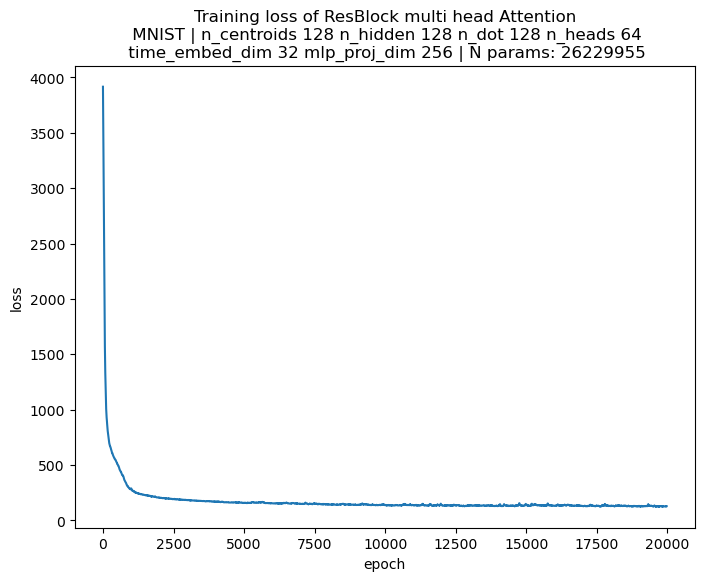

In [36]:
num_params = sum(p.numel() for p in mmres.parameters() if p.requires_grad)
print("number of parameters", num_params)
# 6 million parameters
ker_wid = 25
smooth_loss_traj = np.convolve(loss_traj, np.ones(ker_wid) / ker_wid, mode='valid')
plt.figure(figsize=[8,6])
plt.plot(smooth_loss_traj)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title(f"Training loss of ResBlock multi head Attention\n MNIST | n_centroids {n_centroids} n_hidden {n_hidden} n_dot {n_dot} n_heads {n_heads}\n time_embed_dim {time_embed_dim} mlp_proj_dim {mlp_proj_dim} "\
          f"| N params: {num_params}")
plt.show()

number of parameters 26229955


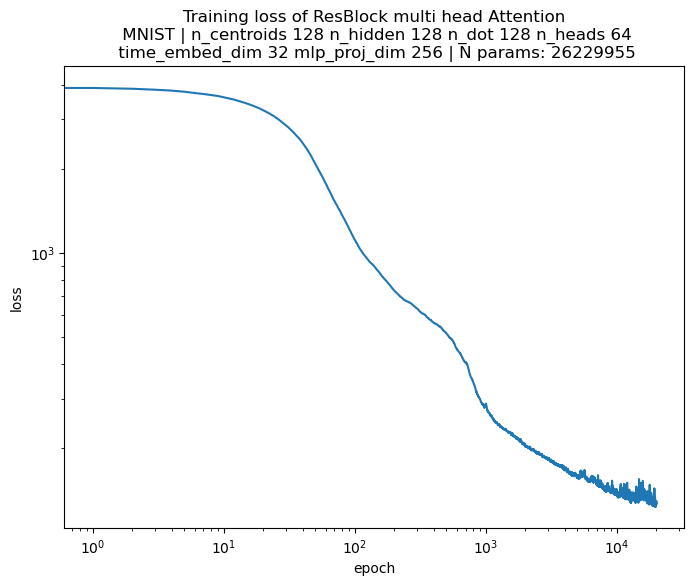

In [37]:
num_params = sum(p.numel() for p in mmres.parameters() if p.requires_grad)
print("number of parameters", num_params)
# 6 million parameters
ker_wid = 25
smooth_loss_traj = np.convolve(loss_traj, np.ones(ker_wid) / ker_wid, mode='valid')
plt.figure(figsize=[8,6])
plt.loglog(smooth_loss_traj)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title(f"Training loss of ResBlock multi head Attention\n MNIST | n_centroids {n_centroids} n_hidden {n_hidden} n_dot {n_dot} n_heads {n_heads}\n time_embed_dim {time_embed_dim} mlp_proj_dim {mlp_proj_dim} "\
          f"| N params: {num_params}")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


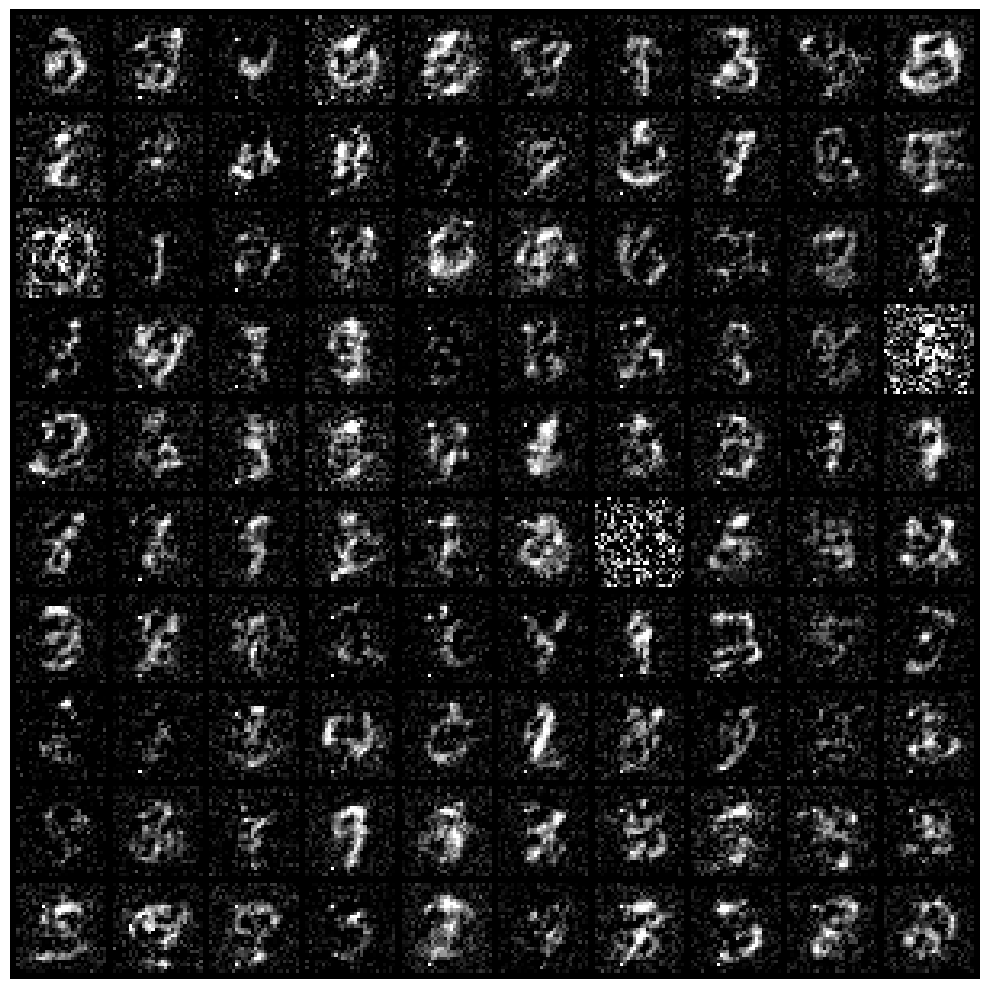

In [38]:
samples = reverse_diffusion_time_dep_torch(mmres, 
        sampN=100, sigma=sigma_max, nsteps=1000, ndim=ndim, 
        exact=False, device="cuda")
samples_denorm = samples * Xtrain.std() + Xtrain.mean()
mtg = make_grid(samples_denorm[:,:,-1].reshape(-1, 1, 28, 28), nrow=10)
plt.figure(figsize=[10,10])
plt.imshow(mtg.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout()
plt.show()

number of parameters 9677328


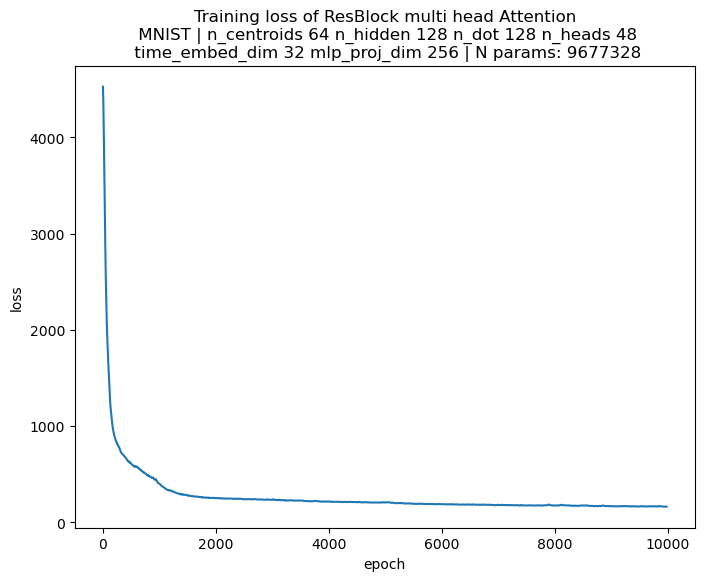

In [31]:
num_params = sum(p.numel() for p in mmha.parameters() if p.requires_grad)
print("number of parameters", num_params)
# 6 million parameters
ker_wid = 25
smooth_loss_traj = np.convolve(loss_traj, np.ones(ker_wid)/ker_wid, mode='valid')
plt.figure(figsize=[8,6])
plt.plot(smooth_loss_traj)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title(f"Training loss of ResBlock multi head Attention\n MNIST | n_centroids {n_centroids} n_hidden {n_hidden} n_dot {n_dot} n_heads {n_heads}\n time_embed_dim {time_embed_dim} mlp_proj_dim {mlp_proj_dim} "\
          f"| N params: {num_params}")
plt.show()

### Multi layer res attention net

In [39]:
from torch.optim.lr_scheduler import CosineAnnealingLR
resblock_cfg = {
    "ndim": Xtrain_norm.shape[1],
    "n_centroids": 64,
    "n_dot": 128,
    "n_hidden": 128,
    "n_heads": 64,
    "time_embed_dim": 64,
    "mlp_proj_dim": 256,
}
deep_mmha = ModulatedSequential(
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
)
device = "cuda"
deep_mmha.to(device)
Xtrain_norm = Xtrain_norm.to(device)
train_cfg = {
    "sigma": 10,
    "lr": 0.001,
    "nepochs": 50000,
    "batch_size": 2048,
}
scheduler_fun = lambda optim: CosineAnnealingLR(optim, T_max=train_cfg["nepochs"], eta_min=1e-4)
print("Parameter count: ", count_parameters(deep_mmha))
deep_mmha = train_score_td(Xtrain_norm, score_model_td=deep_mmha,
        **train_cfg,scheduler_fun=scheduler_fun, device="cuda")

Parameter count:  78564201


step 2 loss 4204.136 lr 1.0e-03:   0%|          | 2/500000 [00:00<7:41:18, 18.06it/s]

step 0 loss 4519.401


step 10356 loss 135.886 lr 1.0e-03:   2%|▏         | 10357/500000 [07:42<6:04:26, 22.39it/s]


KeyboardInterrupt: 

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
resblock_cfg = {
    "ndim": Xtrain_norm.shape[1],
    "n_centroids": 64,
    "n_dot": 64,
    "n_hidden": 64,
    "n_heads": 4,
    "time_embed_dim": 128,
    "mlp_proj_dim": 1024,
}
deep_mmha = ModulatedSequential(
    ModulatedResBlock(**resblock_cfg),
    ModulatedResBlock(**resblock_cfg),
    # ModulatedResBlock(**resblock_cfg),
    # ModulatedResBlock(**resblock_cfg),
)
device = "cuda"
deep_mmha.to(device)
Xtrain_norm = Xtrain_norm.to(device)
train_cfg = {
    "sigma": 10,
    "lr": 0.001,
    "nepochs": 100000,
    "batch_size": 16384,
}
scheduler_fun = lambda optim: CosineAnnealingLR(optim, T_max=train_cfg["nepochs"], eta_min=1e-5)
print("Parameter count: ", count_parameters(deep_mmha))
deep_mmha = train_score_td(Xtrain_norm, score_model_td=deep_mmha,
        **train_cfg,scheduler_fun=scheduler_fun)
# Parameter count:  7371561
# step 0 loss 4426.592
# step 19999 loss 108.260: 100%|██████████| 20000/20000 [27:11<00:00, 12.26it/s]

In [ ]:
train_cfg = {
    "sigma": 10,
    "lr": 0.0005,
    "nepochs": 50000,
    "batch_size": 2048,
}
deep_mmha = train_score_td(Xtrain_norm, score_model_td=deep_mmha,
        **train_cfg,)

In [ ]:
samples = reverse_diffusion_time_dep(deep_mmha, sampN=100, sigma=sigma_max, nsteps=1000, ndim=ndim, exact=False)

In [ ]:
mtg = make_grid(torch.from_numpy(samples[:,:,-1].reshape(-1, 1, 28, 28)), nrow=10)
plt.figure(figsize=[10, 10])
plt.imshow(mtg.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout()
plt.show()

